#THE DATASET IS TAKEN FROM KAGGLE, ITS A DATASET FROM YESBANK WHERE INFORMATION ABOUT ITS STOCKPRICE IS GIVEN, WE ARE GOING TO MAKE ARIMA TIME SERIES MODEL WHICH WILL PREDICT THE CLOSING VALUE WITH TIME

In [1]:

import pandas as pd
df=pd.read_csv('YesBank_StockPrices.csv')
df.head()
import warnings
warnings.filterwarnings('ignore')

In [2]:
columns=['Open','High','Low']
df=df.drop(columns,axis=1)

In [3]:
df.tail()

,Date,Close
180,Jul-20,11.95
181,Aug-20,14.37
182,Sep-20,13.15
183,Oct-20,12.42
184,Nov-20,14.67


##CONVERTING THE DATE IN A PROPER DATE TIME FORMAT USING DATETIME.STRPTIME 

In [4]:
from datetime import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b-%y'))

In [5]:
df.set_index('Date',inplace=True)

In [6]:
df.head()

,Close
Date,
2005-07-01,12.46
2005-08-01,13.42
2005-09-01,13.30
2005-10-01,12.99
2005-11-01,13.41


##VISUALIZING THE DATA

<AxesSubplot:xlabel='Date'>

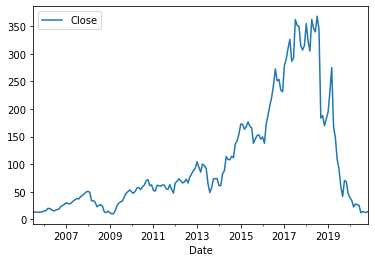

In [7]:
import matplotlib.pyplot as plt
df.plot()

#ITS A NON SEASONAL DATASET AS THE GRAPH IS NOT REPEATING AFTER A PARTICULAR TIME , HENCE WE CAN MAKE A  ARIMA MODEL

##CHECKING FOR STATIONARITY

In [8]:
from statsmodels.tsa.stattools import adfuller
def ad_fuller_test(close):
    result=adfuller(close)
    labels=['Test statistics','p-value','lags_used','number of observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1]<=0.05:
        print("stationary")
    else:
        print("non stationary")

In [9]:
ad_fuller_test(df['Close'])

Test statistics : -1.9064091411726556
p-value : 0.32905208150044
lags_used : 14
number of observations : 170
non stationary


#CONVERTING TO STATIONARY

##DIFFERENCING

In [10]:
df['Seasonal_First_Diff']=df['Close']-df['Close'].shift(1)

In [11]:
df.head(15)

,Close,Seasonal_First_Diff
Date,,
2005-07-01,12.46,NaN
2005-08-01,13.42,0.96
2005-09-01,13.30,-0.12
2005-10-01,12.99,-0.31
2005-11-01,13.41,0.42
2005-12-01,13.71,0.30
2006-01-01,15.33,1.62
2006-02-01,16.12,0.79
2006-03-01,20.08,3.96


In [12]:
ad_fuller_test(df['Seasonal_First_Diff'].dropna())

Test statistics : -2.0566081474846993
p-value : 0.2623166235310913
lags_used : 14
number of observations : 169
non stationary


In [13]:
df['Seasonal_2_Diff']=df['Seasonal_First_Diff']-df['Seasonal_First_Diff'].shift(1)
ad_fuller_test(df['Seasonal_2_Diff'].dropna())

Test statistics : -6.058351845983153
p-value : 1.2295785955119713e-07
lags_used : 13
number of observations : 169
stationary


##NOW THE DATASET HAS BEEN MADE STATIONARY I.E IT HAS A FIXED MOVING MEAN AND VARIANCE , NOW WE CAN APPLY ARIMA MODEL TO IT

<AxesSubplot:xlabel='Date'>

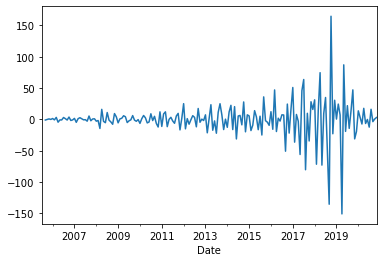

In [14]:
df['Seasonal_2_Diff'].plot()


ARIMA stands for Autoregressive Integrated Moving Average Model. It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.
So, ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
ARIMA Models are specified by three order parameters: (p, d, q),

where,

p is the order of the AR term(number of lags used as predictors)

q is the order of the MA term(number of lagged forecast errors)

d is the number of differencing required to make the time series stationary

 #AR model
An Auto Regressive (AR) model is one where Yt depends only on its own lags.

That is, Yt is a function of the lags of Yt. It is depicted by the following equation -
yt=c+ϕ1yt−1+ϕ2yt−2+⋯+ϕpyt−p+εt, y t = c + ϕ 1 y t − 1 + ϕ 2 y t − 2 + ⋯ + ϕ p y t − p + ε t , where εt is white noise.

ϕ->coefficient of lags estimated ny the model

c->intercept term also estimated by the model

yt−p->lags

#MA model

Likewise a Moving Average (MA) model is one where Yt depends only on the lagged forecast errors. It is depicted
by the following equation -
yt=c+εt+θ1εt−1+θ2εt−2+⋯+θqεt−q, y t = c + ε t + θ 1 ε t − 1 + θ 2 ε t − 2 + ⋯ + θ q ε t − q , where εt is white noise.

ϕ->coefficient of forecast errors estimated ny the model

c->intercept term also estimated by the model

yt−n->forecast errors


#An ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR 
and the MA terms. So the equation of an ARIMA model becomes :
    
yt=c+ϕ1yt−1+ϕ2yt−2+⋯+ϕpyt−p+εt, y t = c + ϕ 1 y t − 1 + ϕ 2 y t − 2 + ⋯ + ϕ p y t − p+θ1εt−1+θ2εt−2+⋯+θqεt−q



#INORDER TO FIND P,D,Q VALUE WE WILL PLOT A CORRELATION AND A PARTIAL AUTOCORRELATION GRAPH

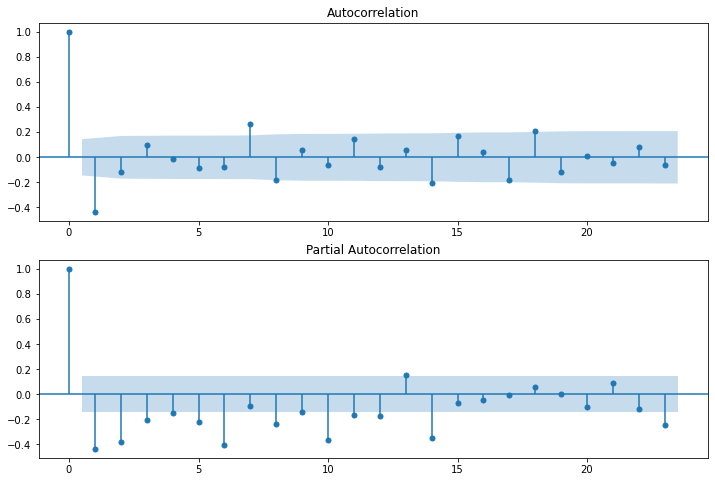

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(df['Seasonal_2_Diff'].iloc[2:],ax=ax1)
ax2=ax1 = fig.add_subplot(212)
fig=plot_pacf(df['Seasonal_2_Diff'].iloc[2:],ax=ax2)

In [50]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Close'],order=(5,2,7))
model_fit=model.fit()

model_fit.summary()

C:\Users\91763\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\91763\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\91763\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                  183
Model:                 ARIMA(5, 2, 7)   Log Likelihood                -797.603
Method:                       css-mle   S.D. of innovations             18.162
Date:                Mon, 20 Sep 2021   AIC                           1623.205
Time:                        00:06:30   BIC                           1668.138
Sample:                    09-01-2005   HQIC                          1641.419
                         - 11-01-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0318      0.029     -1.107      0.268      -0.088       0.024
ar.L1.D2.Close    -1.7430      0.147    -11.870      0.000      -2.031      -1.455
ar.L2.D2.Close    -2.3119      0.230    -10.060      0.000      -2.762      -1.861
ar.L3.D2.Close    -2.0200      0.283     -7.148      0.000      -2.574      -1.466
ar.L4.D2.Close    -1.3233      0.191     -6.938      0.000      -1.697      -0.949
ar.L5.D2.Close    -0.5165      0.106     -4.882      0.000      -0.724      -0.309
ma.L1.D2.Close     0.8876      0.168      5.284      0.000       0.558       1.217
ma.L2.D2.Close     0.6682      0.164      4.086      0.000       0.348       0.989
ma.L3.D2.Close    -0.1321      0.137     -0.968      0.333      -0.400       0.135
ma.L4.D2.Close    -0.7386      0.078     -9.510      0.000      -0.891      -0.586
ma.L5.D2.Close    -0.9722      0.122     -7.968      0.000      -1.211      -0.733
ma.L6.D2.Close    -0.8203      0.166     -4.947      0.000      -1.145      -0.495
ma.L7.D2.Close     0.1075      0.138      0.781      0.435      -0.162       0.377
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0512           -1.0846j            1.0858           -0.2425
AR.2            0.0512           +1.0846j            1.0858            0.2425
AR.3           -0.6647           -0.8878j            1.1090           -0.3523
AR.4           -0.6647           +0.8878j            1.1090            0.3523
AR.5           -1.3351           -0.0000j            1.3351           -0.5000
MA.1           -1.0626           -0.0000j            1.0626           -0.5000
MA.2           -0.6170           -0.7870j            1.0000           -0.3558
MA.3           -0.6170           +0.7870j            1.0000            0.3558
MA.4            0.0866           -0.9962j            1.0000           -0.2362
MA.5            0.0866           +0.9962j            1.0000            0.2362
MA.6            1.0000           -0.0000j            1.0000           -0.0000
MA.7            8.7539           -0.0000j            8.7539           -0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

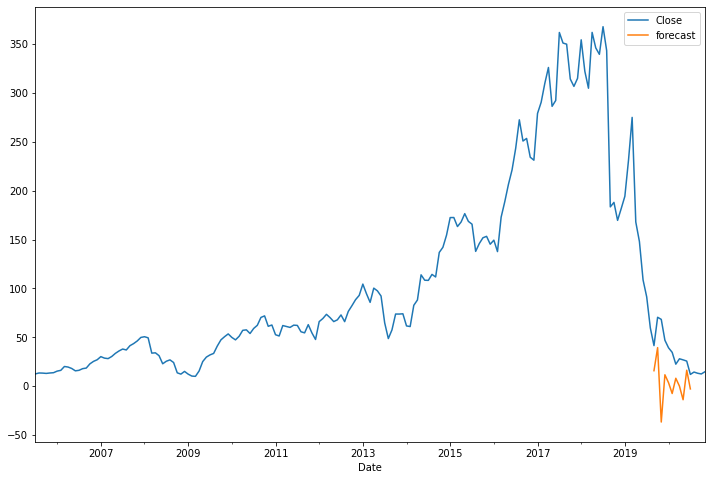

In [51]:
df['forecast']=model_fit.predict(start=170,end=180,dynamic=True)
df[['Close','forecast']].plot(figsize=(12,8))